# Modeling frequencies of the longitudinal mode

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from lazypredict.Supervised import LazyRegressor
from flaml import AutoML
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.linear_model import PoissonRegressor, Ridge

In [2]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

In [3]:
df_params.head()

,dp_no,dim_x,dim_y,dim_z,nb_slots_x,slot_x_length,slot_x_distance,nb_slots_z,slot_z_length,slot_z_distance,...,disp_long_396,disp_long_397,disp_long_398,disp_long_399,sum_sensi,coupling_long,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,1001,175.06,121.95,240.31,4,75.99,43.23,2,78.22,59.51,...,0.17,0.14,0.14,0.15,0.00,0.96,0,0,0,1
1,1002,173.45,122.77,238.13,4,81.17,45.86,2,78.92,57.21,...,0.17,0.15,0.14,0.14,0.00,0.96,0,0,0,1
2,1003,175.85,116.71,238.10,4,77.53,45.26,2,80.10,49.22,...,0.29,0.27,0.28,0.28,0.00,0.99,0,0,0,1
3,1004,173.51,116.37,238.30,4,82.43,51.01,2,74.76,50.84,...,0.24,0.18,0.18,0.19,0.00,0.97,0,0,0,1
4,1005,175.60,118.72,241.04,4,76.58,45.98,2,78.77,64.70,...,0.26,0.26,0.28,0.29,0.00,0.99,0,0,0,1


The column names of the DataFrame df_params are listed in the text file df_params_cols.txt, to get easier the column index later. The explanatory variables and the target variable are selected from the loaded dataframe:
* The explanatory variables are basically the geometrical parameters (the numbers of slots both directions are excluded, since that are representated by the encoded variables slot_2-2, ... slot_4-2)
* The target variable is the frequency of the longitudinal mode, which is one of the 100 frequencies calculated in the FEM simulation. Since the longitudinal mode is identified during the data generation, the frequency was stored in the variable "freq_long"

In [4]:
lst_param = df_params.columns.to_list()

# Start with design points belonging to the slot class "4-2" only

In [5]:
# Explanatory variables
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
# Target variable
target = 'freq_long'

For the first step, the model is trained only on the dataset with one of the 4 slot classes. Only numerical variables are present in the data set.

In [6]:
# Select only the data of the slot class 4-2
slot_class = '4-2'
idx = df_params[df_params['slot_class'] == slot_class].index
X = df_params.loc[idx, lst_expl]
y = df_params.loc[idx, target]

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X

,dim_x,dim_y,dim_z,slot_x_length,slot_x_distance,slot_z_length,slot_z_distance,chamfer_x_dim_y,chamfer_x_dim_z,chamfer_y_dim_x,...,elefoot_x,elefoot_z,cut_x_start,cut_x_end,cut_x_depth,cut_z_start,cut_z_end,cut_z_depth,seg_x_out,seg_z_out
0,0.05,0.68,0.27,-0.96,-1.18,-0.11,0.29,0.97,0.35,-1.23,...,1.21,1.11,-1.00,1.55,-1.18,-1.00,1.19,-0.39,1.20,-0.27
1,-1.34,0.96,-1.62,1.03,-0.53,0.16,-0.15,0.29,-0.02,1.04,...,-0.83,0.94,0.04,-0.06,1.63,-0.76,-0.14,1.59,0.37,-0.14
2,0.74,-1.14,-1.65,-0.37,-0.68,0.62,-1.69,-1.32,-0.01,-0.65,...,0.63,-0.86,-1.64,0.31,-0.94,-1.42,-0.87,-1.22,0.52,1.81
3,-1.29,-1.26,-1.47,1.51,0.74,-1.44,-1.38,0.36,0.49,-1.22,...,-1.19,1.03,1.17,-1.43,1.14,0.68,0.11,-1.08,-0.88,1.06
4,0.52,-0.44,0.90,-0.74,-0.50,0.11,1.29,1.01,0.17,1.11,...,0.22,-1.11,-0.31,0.79,-1.35,-0.71,-0.83,-1.28,0.58,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.26,1.33,1.36,1.66,-1.29,-1.47,0.49,-1.42,-0.26,1.27,...,0.91,0.24,-0.79,-0.79,-0.40,-0.58,-0.80,0.15,1.41,-0.75
1996,-0.06,0.15,-1.24,1.28,-0.80,-0.09,-0.33,-0.66,1.52,-1.64,...,-1.46,0.65,-0.35,1.04,0.65,0.02,1.67,-0.98,0.68,0.31
1997,0.84,-1.00,-0.74,-0.83,-1.38,0.87,-1.08,-0.49,-0.74,0.30,...,-1.12,0.58,-0.62,1.60,1.43,-1.48,1.53,0.32,1.30,1.23
1998,-1.40,-1.34,-1.32,0.62,-0.04,1.11,1.33,-1.72,0.75,-0.23,...,0.36,-0.81,0.27,-0.15,-1.12,-1.66,1.60,1.70,-0.08,-1.60


First attempt of modelling with a simple linear regressor

In [8]:
# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [9]:
# Linear regressor with standard parameters. The default scoring is the coefficient of determination R² of the prediction
model = LinearRegression()

model.fit(X_train, y_train)
print('Score R² of the train set:', model.score(X_train, y_train))
print('Score R² of the test set::', model.score(X_test, y_test))

Score R² of the train set: 0.9858506216802931
Score R² of the test set:: 0.9865220098099048


Calculation of the residuals: difference between real values and predictions

In [10]:
y_pred = model.predict(X_test)
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Maximal frequency error (residual):', max(np.abs(y_pred-y_test)))

Root Mean Square Error (RMSE): 58.481244110248845
Maximal frequency error (residual): 241.7785212792296


Visualization of the residuals

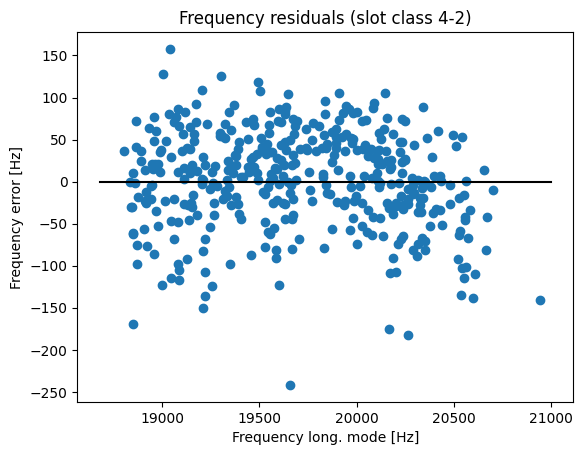

In [11]:
y_delta = y_pred-y_test
plt.figure()
plt.scatter(y_test, y_delta)
plt.plot((y.min(), y.max()), (0, 0), color='black')
plt.xlabel('Frequency long. mode [Hz]')
plt.ylabel('Frequency error [Hz]')
plt.title('Frequency residuals (slot class 4-2)')
plt.show()

Max. frequency error: 241.7785212792296


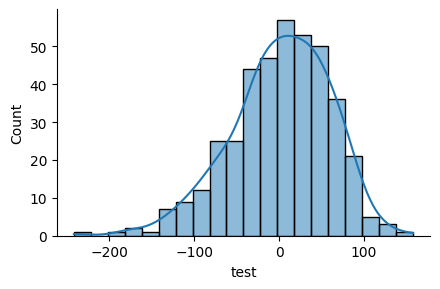

In [32]:
# Distribution of the residuals
g = sns.displot(data=y_delta, kind='hist', bins=20, kde=True, height=3, aspect=1.5)
g.set_axis_labels('test');

print ('Max. frequency error:', np.abs(y_delta).max())

The first linear model predict the frequency of the longitudinal mode with an error around 1%. This error is quite low but only the geometries with the slot class 4-2 were considered.

# Benchmark of regression estimators

All slot classes will be considered. In order to find the best estimator for this problem, we will follow these steps:
* Scaling of the explanatory variables
* Splitting of the data in train and test sets
* Runs with LazyPredict and FLAML to get a first overview of the most appropriate estimators
* Evaluation of the score (R² coefficient of determination) by cross-validation of the best estimators  

In [9]:
# Explanatory variables: all slot classes are considered, we add the 4 encoded columns to the selected dataset
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
# Target variable is the frequency of the longitudinal mode
target = 'freq_long'

X = df_params[lst_expl + lst_slot_class]
y = df_params[target]

In [10]:
# Scale all explanatory variables, except the slot class encoded columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[lst_expl])
X = pd.concat([pd.DataFrame(X_scaled, columns=lst_expl, index=X.index), X[lst_slot_class]], axis=1)

Visualization of the scaled numerical variables

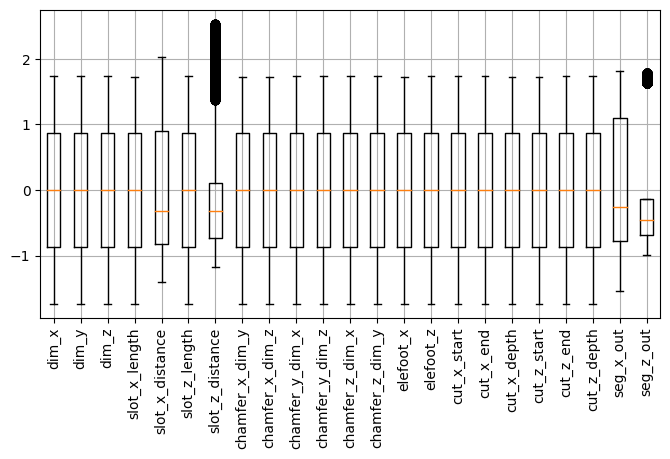

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.boxplot(X[lst_expl], labels=lst_expl)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

The tools LazyPredict and FLAML are used to make a first selection of the best estimators (https://www.blopig.com/blog/2022/12/two-useful-modules-to-help-you-find-the-best-ml-model-for-your-task/):
* LazyPredict trains only using default parameters while FLAML searches different parameters
* FLAML is more customisable: it is possible to set time budget, optimization metrics and estimators
* FLAML accepts a cross-validation strategy (Repeated Stratified K-Fold Cross-Validation) if a number of splits is provided (https://www.restack.io/p/open-source-ai-diagnostic-tools-answer-flaml-cross-validation-cat-ai)

In [12]:
# New Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

LazyPredict requires explicit test data, but it is not possible to provide test data to FLAML. The input data set will be different:
* The train and test sets will be given in the LazyPredict regressor
* The whole data set will be provided to FLAML

In [15]:
# Lazypredict does a simple train/test splita and trains only using default parameters
reg = LazyRegressor(verbose=1, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# List of the 5 best models found by LazyPredict
models.head()

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9246161271483191, 'Adjusted R-Squared': 0.9233197165960927, 'RMSE': 137.59682057597303, 'Time taken': 2.8159055709838867}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9526048060676634, 'Adjusted R-Squared': 0.9517897294841137, 'RMSE': 109.1029085208244, 'Time taken': 4.248324155807495}
{'Model': 'BayesianRidge', 'R-Squared': 0.9788818008904601, 'Adjusted R-Squared': 0.978518621670105, 'RMSE': 72.82787131895405, 'Time taken': 0.0304410457611084}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.906529241826687, 'Adjusted R-Squared': 0.904921782928165, 'RMSE': 153.21703675925409, 'Time taken': 0.6934559345245361}
{'Model': 'DummyRegressor', 'R-Squared': -0.001371421958669572, 'Adjusted R-Squared': -0.01859245915158958, 'RMSE': 501.49519070696533, 'Time taken': 0.017483234405517578}
{'Model': 'ElasticNet', 'R-Squared': 0.8744134707234339, 'Adjusted R-Squared': 0.8722537023855567, 'RMSE': 177.59907735810356, 'Time taken': 0.02521538734436035}
{

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.99,0.99,59.20,0.47
HistGradientBoostingRegressor,0.99,0.99,59.44,1.54
XGBRegressor,0.98,0.98,68.64,0.36
PoissonRegressor,0.98,0.98,72.05,0.03
TransformedTargetRegressor,0.98,0.98,72.82,0.02


In [14]:
# FLAML finds the best estimators in the given time bugdet (here 10 minutes) 
automl = AutoML()
automl_settings = {
    'task': 'regression',
     'metric': 'r2',
     'time_budget': 300,
     'n_splits': 5,
     'log_file_name': 'automl-frequencies.log'
     }
automl.fit(X_train, y_train, **automl_settings)

print ('The best estimator found my FLAML:', automl.best_estimator)
print('Best config:', automl.best_config_per_estimator[automl.best_estimator])

y_pred = automl.predict(X_test)
print('r2 score:', r2_score(y_test, y_pred))

[flaml.automl.logger: 05-17 11:57:16] {1728} INFO - task = regression
[flaml.automl.logger: 05-17 11:57:16] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-17 11:57:16] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 05-17 11:57:16] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 05-17 11:57:16] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-17 11:57:16] {2393} INFO - Estimated sufficient time budget=1115s. Estimated necessary time budget=8s.
[flaml.automl.logger: 05-17 11:57:16] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.5491,	best estimator lgbm's best error=0.5491
[flaml.automl.logger: 05-17 11:57:16] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-17 11:57:17] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.5491,	best estimator lgbm's best error=0.5491
[flaml.automl.logger: 05-17 11:57:17] {2258} I

# Cross validation

The gradient based regressors LightGBM, HistGradientBoosting and XGBoost are the most promising estimators. For comparision purposes, other models are taken in the model dictionaries for the cross-validation too:

In [28]:
dict_models = {
            'LGBM': LGBMRegressor(force_col_wise=True),
            'HistGradient': HistGradientBoostingRegressor(),
            'XGB': xgb.XGBRegressor(),
            'Poisson': PoissonRegressor(),
            'Ridge':  Ridge(),
            'GradientBoosting': GradientBoostingRegressor(),
            'MLP': MLPRegressor(max_iter=2000)
        }

In [32]:
for name, model in dict_models.items():

    print ('-----------------------')
    print ('** Model: ' + name)

    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    print ('Scores R² of the 5 splits:', scores)
    print ('Score mean R²:', scores.mean())
    print ('Score standard deviation R²:', scores.std())


-----------------------
** Model: LGBM
[LightGBM] [Info] Total Bins 5854
[LightGBM] [Info] Number of data points in the train set: 5113, number of used features: 27
[LightGBM] [Info] Start training from score 19961.563983
[LightGBM] [Info] Total Bins 5857
[LightGBM] [Info] Number of data points in the train set: 5113, number of used features: 27
[LightGBM] [Info] Start training from score 19954.880512
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 5114, number of used features: 27
[LightGBM] [Info] Start training from score 19965.895926
[LightGBM] [Info] Total Bins 5860
[LightGBM] [Info] Number of data points in the train set: 5114, number of used features: 27
[LightGBM] [Info] Start training from score 19961.584252
[LightGBM] [Info] Total Bins 5861
[LightGBM] [Info] Number of data points in the train set: 5114, number of used features: 27
[LightGBM] [Info] Start training from score 19957.704754
Scores R² of the 5 splits: [0.98436144 0.98589

### Conclusion

The best score mean and standard deviation are reached by the HistGradientBoosting estimator (not tested by FLAML). The second best estimator is the LightGBM, which should preferred for very large datasets. In the next step, the hyperparameters of both models will be tuned with a Bayesian optimization approach.